In [91]:

%%latex
$$\textbf{Code template to be performed on multi-processors}$$
$$\\$$
There are two important things to know.
$$\\$$
First, the script takes N 3D-boxes filled with stars 
and performs N simulations (each relates to a specific 3D-box) based on provided data. Each simulation is divided
into $12\times NSIDE^2$ sub-simulations which correspond to a specific position of an observer characterized by 
spherical angles $\varphi$ and $\theta$ ($r$ is always the same for all sub-simulations). Thus, we get images of the 
same stars from different angles.
$$\\$$
Second. Initially, we have a 3D box, where the stars' positions are written in Cartesian coordinates. Then we 
perform a coordinate transformation (rotation). The basis vectors are as those of the spherical coordiate system
(see the image below). Here we want to emphasize that we only rotated our coordinate system. Origin stays the same. 
The $\mathbf{e}_{r}$ $\mathbf{e}_{\phi}$ and $\mathbf{e}_{\theta}$ basis vectors are pictured on the unit sphere surface for
visual convenience.
$$\\$$

Suppose, we have a star with coordinates (x,y,z) in 3D data box reference frame. We want to look at this star at a
fixed distance from some arbitrary point in space (the point is characterized by $\theta$ and $\varphi$). So the method
to do this is to rotate coordinate system and project the star onto the plane with normal vector $\mathbf{e}_{r}$. 
In the equation below $x_2$ and $x_3$ coordinates tell us the position of the star on the plane.
$$\\$$
$$
\left[ \begin{array}{c} x_1 \\ x_2 \\ x_3 \end{array} \right] = 
\begin{bmatrix} sin(\theta)cos(\varphi) & sin(\theta)sin(\varphi) & cos(\theta)\\ 
       cos(\theta)cos(\varphi)& cos(\theta)sin(\varphi) &  -sin(\theta)\\
       -sin(\varphi)  & cos(\varphi)  & 0 \end{bmatrix} 
\times \left[ \begin{array}{c} x \\ y \\ z \end{array} \right]
$$
                  

<IPython.core.display.Latex object>

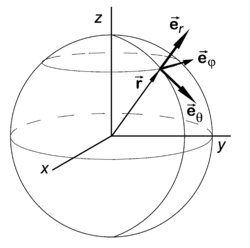

In [69]:
from IPython.display import Image
Image(filename='250px-Spherical_unit_vectors.png')

In [2]:
%matplotlib notebook

import yt
import glob
import numpy              as np
import healpy             as hp
import cosmolopy          as cp
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import scipy.ndimage      as ndimage

from scipy                import signal
from scipy.interpolate    import interp1d
from scipy.interpolate    import interp2d
from scipy.interpolate    import RegularGridInterpolator
from scipy                import integrate
from astropy.io           import fits
from astropy              import wcs
from mpl_toolkits.mplot3d import Axes3D

In [48]:
# [parameters for arg pars]

filter_name = 'hst/wfc3/IR/f160w.dat'
start,stop = 0,2                        # [number of simulations (start-stop)]
radius = 25                             # [radius of a sphere in kpc]
mars2pix = 60                           # [milli-arcsec in pixel]
zero_point = 25.94                      # [noise zero point]
NSIDE = 1

In [49]:
# ISM Transmition function

table = np.loadtxt('table_transmition_ISM.dat')
lam_rest   = table[1:,0]
z          = table[0,1:]
trans_coef = table[1:,1:]

transmition_function = interp2d(z, lam_rest, trans_coef)

In [50]:
# To select a filter

temp_filters = open('data/FILTER.RES.latest', 'r')
filters = []
filters_names = []
first = True

for line in temp_filters:

    if line[0] == ' ':
        if not first:
            filters.append(np.array(temp))

        first = False
        filters_names.append(line.split())
        temp = []

    else:
        temp.append(np.array(line.split()).astype('float'))

filters.append(np.array(temp))
filters = np.array(filters)

for ifilt in range(len(filters_names)):
    if filters_names[ifilt][1] == filter_name:
        filter_b = np.array([filters[ifilt][:,1],filters[ifilt][:,2]])
        filter_b = np.transpose(filter_b)

F_b = interp1d(filter_b[:,0], filter_b[:,1],fill_value=0.0)
left,right = np.min(filter_b[:,0]),np.max(filter_b[:,0])

In [51]:
def filter_range(a,b,x):

    position_in_lam_array = []
    lambdas               = []

    for i in range(0,len(x)):

        if (a<=x[i] and x[i]<=b):

            position_in_lam_array.append(i)
            lambdas.append(x[i])

    lambdas = np.array(lambdas)
    position_in_lam_array = np.array(position_in_lam_array)

    indices = np.argsort(lambdas)

    return position_in_lam_array[indices]

In [52]:
def pixel_integration(pixel,lam):

    nu = 2.99792458e10/(lam/1e8)

    mtr_int = np.zeros_like(pixel[:,:,0])

    for i in range(0,len(pixel[:,0,0])):
        for j in range(0,len(pixel[0,:,0])):

            mtr_int[i,j] = integrate.trapz( pixel[i,j,::-1] * 3.828e33 * F_b(lam[::-1]), nu[::-1]) \
                           / (4 * np.pi * np.power(lum_dist*3.0857e18*1e6,2))
    return mtr_int

In [53]:
def noise_PSF(theta, phi, angle_idx, angles, sim_idx):

    global image_int

    pixels_with_noise = fits.open('hlsp_hlf_hst_wfc3-60mas_goodss_f160w_v1.0_sci.fits')[0].data[15000:15000+nbins,10000:10000+nbins]
    coeff = 10 ** (0.4 * (zero_point + 48.6))

    plt.figure(2*sim_idx+1)
    ax1 = plt.subplot(int(angles/4),4,angle_idx+1)
    plt.imshow(np.log10(image_int), interpolation='nearest')
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.set_title(str(round(theta,1)) + ' ' + str(round(phi,1)))

    image_int *= coeff
    image_int += pixels_with_noise

    PSF = fits.open('psf_wfc3ir_f160w.fits')[0].data
    blurred = signal.fftconvolve(image_int, PSF, mode='same')

    plt.figure(2*sim_idx+2)
    ax2 = plt.subplot(int(angles/4),4,angle_idx+1)
    plt.imshow(blurred, interpolation='nearest',cmap=plt.cm.gray,vmin=np.min(blurred), vmax=np.max(blurred))
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.set_title(str(round(theta,1)) + ' ' + str(round(phi,1)))

In [54]:
def gal(theta,phi):

    global nbins, lam_list, luminosity_distance, lum_dist, image_int

    cartesian_vec_coord = np.vstack([x,y,z])
    rotated_vec_coord = np.array(lab2rot(cartesian_vec_coord,theta=theta,phi=phi))

    coord_prj_e_r     = rotated_vec_coord[0,:]
    coord_prj_e_theta = rotated_vec_coord[1,:]
    coord_prj_e_phi   = rotated_vec_coord[2,:]

    ang_dist = cp.distance.angular_diameter_distance(redshift, **cp.fidcosmo)
    lum_dist = ang_dist * (1+redshift) * (1+redshift)

    theta_milliarcsec = ( 2 * radius * 1e3 ) / ( ang_dist * 1e6  ) * ( 206265.0 * 1e3 )
    nbins =  int(theta_milliarcsec * 1/mars2pix)

    filter_lam = filter_range(left,right,lam_list)

    image = np.zeros([nbins, nbins, 3, len(filter_lam)])
    image_int = np.zeros([nbins, nbins, 3, 0])

    index = 0

    for i in filter_lam:

        interp = interp2d(dx, dy, lookup[i, :, :])
        temp = m.copy()

        for j in range(len(m)):
            temp[j] *= transmition_function(redshift,lam_list[i]/(1+redshift))[0]*interp(met[j], t[j])[0]

        e_theta_edges = np.linspace(-data.radius, data.radius, nbins+1)
        e_phi_edges   = np.linspace(-data.radius, data.radius, nbins+1)

        H, X, Y = np.histogram2d(coord_prj_e_theta, coord_prj_e_phi, bins=(e_theta_edges, e_phi_edges), weights = temp)
        image[:, :, 0, index] = H

        index += 1

    image_int = pixel_integration(image[:,:,0,:],lam_list[filter_lam])

In [55]:
def rot2lab(V,theta,phi):

    mtr = np.matrix([[ np.sin(theta)*np.cos(phi), np.cos(theta)*np.cos(phi),-np.sin(phi)],
                     [ np.sin(theta)*np.sin(phi), np.cos(theta)*np.sin(phi), np.cos(phi)],
                     [ np.cos(theta)            ,-np.sin(theta)            , 0          ]])


    return np.squeeze(np.array(np.dot(mtr,V)))

In [56]:
def lab2rot(V,theta,phi):

    mtr = np.matrix([[ np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)],
                     [ np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi),-np.sin(theta)],
                     [-np.sin(phi)              , np.cos(phi)              , 0            ]])

    return np.squeeze(np.array(np.dot(mtr,V)))

yt : [WARNING  ] 2016-08-16 15:57:30,053 DeltaDC != 0, which implies auni != abox.  Be sure you understand which expansion parameter is appropriate for your use! (Gnedin, Kravtsov, & Rudd 2011)
yt : [INFO     ] 2016-08-16 15:57:30,063 Parameters: current_time              = 909401005.0300856 yr
yt : [INFO     ] 2016-08-16 15:57:30,064 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2016-08-16 15:57:30,066 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2016-08-16 15:57:30,067 Parameters: domain_right_edge         = [ 32.  32.  32.]
yt : [INFO     ] 2016-08-16 15:57:30,069 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2016-08-16 15:57:30,069 Parameters: current_redshift          = 6.124184822106263
yt : [INFO     ] 2016-08-16 15:57:30,070 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2016-08-16 15:57:30,070 Parameters: omega_matter              = 0.3035999834537506
yt : [INFO     ] 2016-08-16 15:57:

{}


yt : [INFO     ] 2016-08-16 15:57:33,593 Loading field plugins.
yt : [INFO     ] 2016-08-16 15:57:33,594 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-08-16 15:57:33,595 Loaded astro (15 new fields)
yt : [INFO     ] 2016-08-16 15:57:33,597 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-08-16 15:57:33,599 Loaded fluid (63 new fields)
yt : [INFO     ] 2016-08-16 15:57:33,602 Loaded fluid_vector (95 new fields)
yt : [INFO     ] 2016-08-16 15:57:33,603 Loaded geometric (111 new fields)
yt : [INFO     ] 2016-08-16 15:57:33,605 Loaded local (111 new fields)
yt : [INFO     ] 2016-08-16 15:57:33,606 Loaded magnetic_field (119 new fields)
yt : [INFO     ] 2016-08-16 15:57:33,607 Loaded my_plugins (119 new fields)
yt : [INFO     ] 2016-08-16 15:57:33,608 Loaded species (121 new fields)
yt : [INFO     ] 2016-08-16 15:57:35,478 Created 8 chunks for ARTIO


Data №  1
Projection [№1 out of 12] (phi, theta) = (45.00, 48.19) deg


<IPython.core.display.Javascript object>


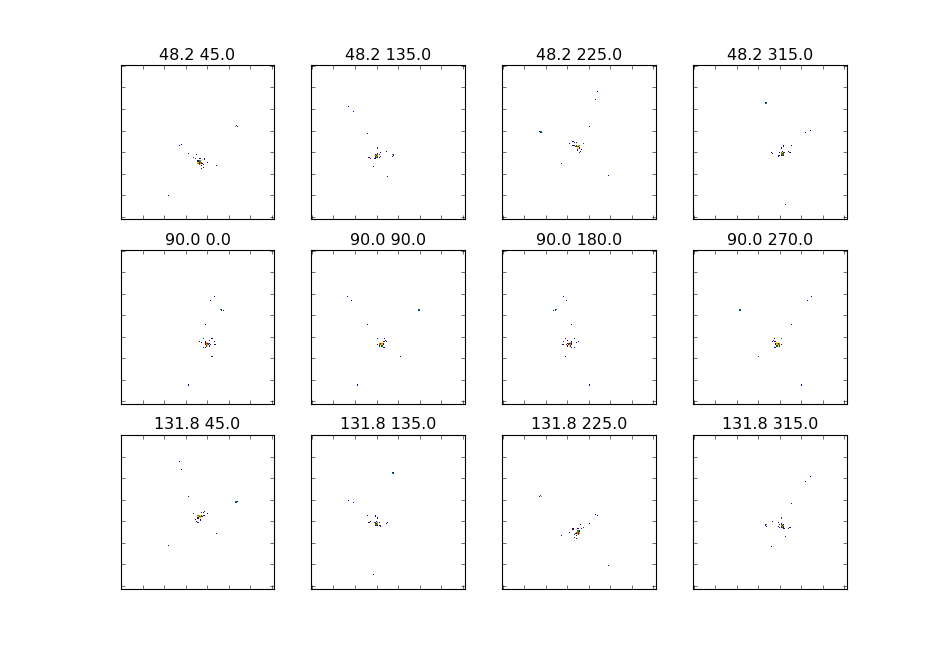

/home/maryhallow/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
CTYPE1  ='RA---TAN'                                                              [astropy.io.fits.card]
CTYPE2  ='DEC--TAN'                                                              [astropy.io.fits.card]
DATE-OBS='2009-12-13'                                                            [astropy.io.fits.card]
TIME-OBS='21:23:07'                                                              [astropy.io.fits.card]
ROOTNAME='ibcj03kdq                                                              [astropy.io.fits.card]
TARGNAME='OMEGACEN                                                               [astropy.io.fits.card]
FILTER1 =                                                                        [astropy.io.fits.card]
FILTER2 =                                                                        [astropy.io.fits.card]


<IPython.core.display.Javascript object>


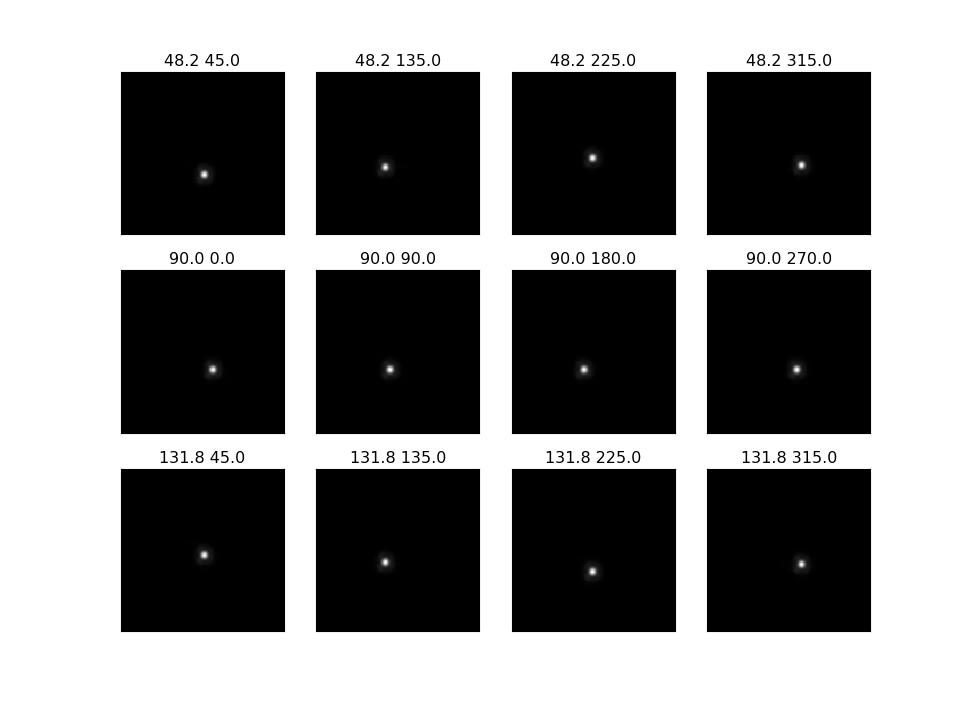

Projection [№2 out of 12] (phi, theta) = (135.00, 48.19) deg
Projection [№3 out of 12] (phi, theta) = (225.00, 48.19) deg
Projection [№4 out of 12] (phi, theta) = (315.00, 48.19) deg
Projection [№5 out of 12] (phi, theta) = (0.00, 90.00) deg
Projection [№6 out of 12] (phi, theta) = (90.00, 90.00) deg
Projection [№7 out of 12] (phi, theta) = (180.00, 90.00) deg
Projection [№8 out of 12] (phi, theta) = (270.00, 90.00) deg
Projection [№9 out of 12] (phi, theta) = (45.00, 131.81) deg
Projection [№10 out of 12] (phi, theta) = (135.00, 131.81) deg
Projection [№11 out of 12] (phi, theta) = (225.00, 131.81) deg
Projection [№12 out of 12] (phi, theta) = (315.00, 131.81) deg


yt : [WARNING  ] 2016-08-16 16:02:23,978 DeltaDC != 0, which implies auni != abox.  Be sure you understand which expansion parameter is appropriate for your use! (Gnedin, Kravtsov, & Rudd 2011)
yt : [INFO     ] 2016-08-16 16:02:23,986 Parameters: current_time              = 683058841.16758 yr
yt : [INFO     ] 2016-08-16 16:02:23,986 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2016-08-16 16:02:23,988 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2016-08-16 16:02:23,989 Parameters: domain_right_edge         = [ 32.  32.  32.]
yt : [INFO     ] 2016-08-16 16:02:23,990 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2016-08-16 16:02:23,991 Parameters: current_redshift          = 7.6209655546310415
yt : [INFO     ] 2016-08-16 16:02:23,992 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2016-08-16 16:02:23,992 Parameters: omega_matter              = 0.3035999834537506
yt : [INFO     ] 2016-08-16 16:02:2

{}


yt : [INFO     ] 2016-08-16 16:02:27,311 Loading field plugins.
yt : [INFO     ] 2016-08-16 16:02:27,313 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-08-16 16:02:27,314 Loaded astro (15 new fields)
yt : [INFO     ] 2016-08-16 16:02:27,315 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-08-16 16:02:27,316 Loaded fluid (63 new fields)
yt : [INFO     ] 2016-08-16 16:02:27,318 Loaded fluid_vector (95 new fields)
yt : [INFO     ] 2016-08-16 16:02:27,319 Loaded geometric (111 new fields)
yt : [INFO     ] 2016-08-16 16:02:27,320 Loaded local (111 new fields)
yt : [INFO     ] 2016-08-16 16:02:27,321 Loaded magnetic_field (119 new fields)
yt : [INFO     ] 2016-08-16 16:02:27,322 Loaded my_plugins (119 new fields)
yt : [INFO     ] 2016-08-16 16:02:27,323 Loaded species (121 new fields)
yt : [INFO     ] 2016-08-16 16:02:29,028 Created 16 chunks for ARTIO


Data №  2
Projection [№1 out of 12] (phi, theta) = (45.00, 48.19) deg


<IPython.core.display.Javascript object>


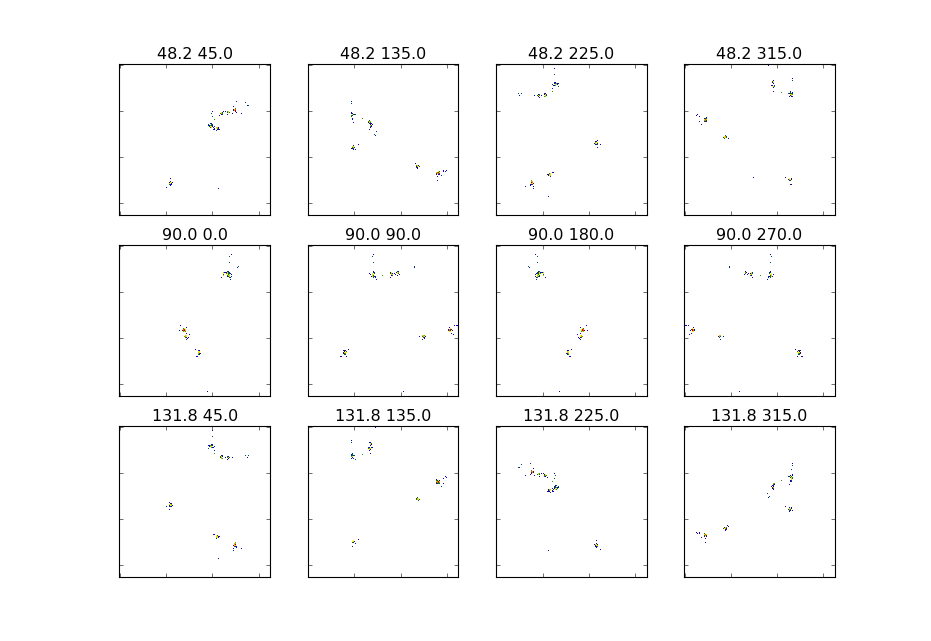

<IPython.core.display.Javascript object>


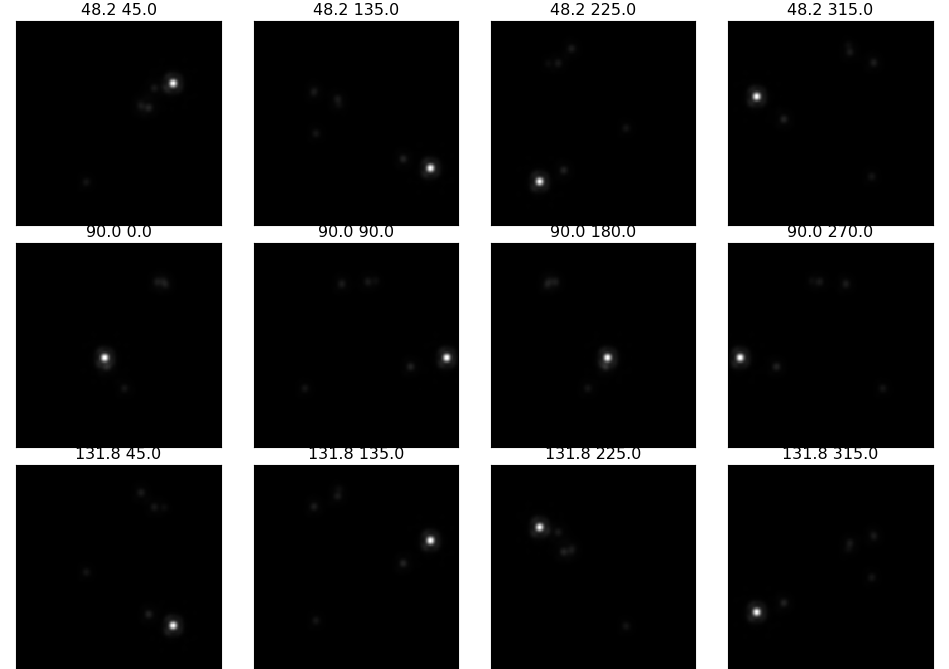

Projection [№2 out of 12] (phi, theta) = (135.00, 48.19) deg
Projection [№3 out of 12] (phi, theta) = (225.00, 48.19) deg
Projection [№4 out of 12] (phi, theta) = (315.00, 48.19) deg
Projection [№5 out of 12] (phi, theta) = (0.00, 90.00) deg
Projection [№6 out of 12] (phi, theta) = (90.00, 90.00) deg
Projection [№7 out of 12] (phi, theta) = (180.00, 90.00) deg
Projection [№8 out of 12] (phi, theta) = (270.00, 90.00) deg
Projection [№9 out of 12] (phi, theta) = (45.00, 131.81) deg
Projection [№10 out of 12] (phi, theta) = (135.00, 131.81) deg
Projection [№11 out of 12] (phi, theta) = (225.00, 131.81) deg
Projection [№12 out of 12] (phi, theta) = (315.00, 131.81) deg


In [59]:
number_of_angles = hp.nside2npix(NSIDE)
theta,phi = hp.pix2ang(NSIDE,np.arange(number_of_angles))

muf_list = glob.glob("./drt/muv.bin*")
files = glob.glob("./rei05B_a0*/rei05B_a*.art")
sorted(files)

for i in range(start,stop):

    pf = yt.load(files[i])

    lam_list = np.zeros(len(muf_list))
    lookup = np.zeros([len(muf_list), 188, 22])

    for l in range(len(muf_list)):

        f = open(muf_list[l])
        header = f.readline()
        f.close()
        d1 = header.split()[0]
        d2 = header.split()[1]
        lam_list[l] = float(header.split()[2])

        data = np.genfromtxt(muf_list[l], skip_header=1)
        lookup[l, :, :] = data[1:,1:]

    dx = data[0, 1:]
    dy = data[1:, 0]

    data = pf.sphere("c", (radius, "kpc"))

    x = np.array(data[('STAR', 'POSITION_X')] - data.center[0])
    y = np.array(data[('STAR', 'POSITION_Y')] - data.center[1])
    z = np.array(data[('STAR', 'POSITION_Z')] - data.center[2])

    m = data[('STAR', 'MASS')].in_units('g')/1.989e33
    met = data[('STAR', 'METALLICITY_SNIa')] + data[('STAR', 'METALLICITY_SNII')]
    t = np.log10(data[('STAR', 'age')].in_units('yr'))
    redshift = pf.current_redshift

    lam_list *= (1+redshift)

    print('Data № ', i+1)

    for j in range(0,len(theta)):

        print('Projection [№%i out of %i] (phi, theta) = (%4.2f, %4.2f) deg' %  (j+1, len(theta),
              phi[j]*360/2/np.pi, theta[j]*360/2/np.pi))

        gal(theta=theta[j],phi=phi[j])
        noise_PSF(theta=theta[j]*360/2/np.pi,phi=phi[j]*360/2/np.pi,angle_idx=j,angles=len(theta),sim_idx=i)

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

<IPython.core.display.Javascript object>


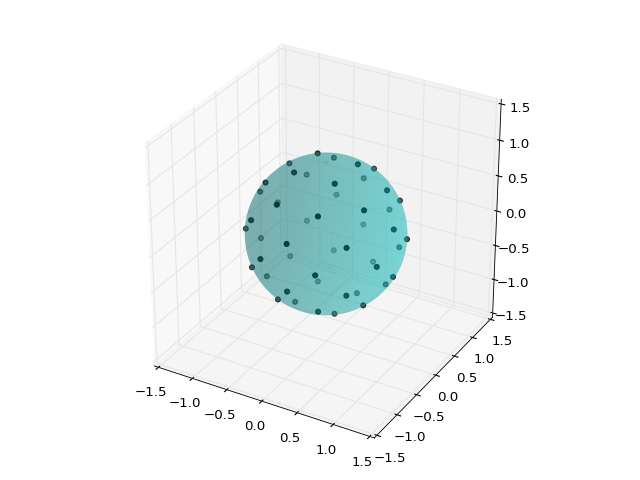

In [5]:
# evenly distributed points on a sphere

NSIDE = 2
fig = plt.figure(0)
ax = fig.add_subplot(111, projection='3d')

phi, theta = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
x = np.sin(phi)*np.cos(theta)
y = np.sin(phi)*np.sin(theta)
z = np.cos(phi)

ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

theta,phi = hp.pix2ang(NSIDE,np.arange(48))

points = np.zeros((len(theta),3))
points[:,0] = np.sin(theta)*np.cos(phi)
points[:,1] = np.sin(theta)*np.sin(phi)
points[:,2] = np.cos(theta)

ax.scatter(points[:,0], points[:,1], points[:,2],c='k')
ax.set_aspect("equal")
plt.tight_layout()